# Studying Tidal streams for galaxies & globular clusters

The purpose of this tutorial is to help *you* simulate tidal streams for mainly dwarf galaxies or globular clusters that orbit a larger galaxy - in this case, the Milky Way. If you need any more information, check out the [galpy documentation](https://docs.galpy.org/en/latest/streamdf.html#new-in-v1-8-particle-spray-modeling-of-streams-with-streamspraydf), the [paper](https://ui.adsabs.harvard.edu/abs/2015MNRAS.452..301F/abstract) from which the model is implemented from, or the implementation [paper](https://ui.adsabs.harvard.edu/abs/2022MNRAS.511.2339Q/abstract).

To start, you need:
- **Current Kinematic Data**: The first step before even running the particle-spray stream model is to instantiate an `Orbit` object. Remember that if you are using a potential that is not `MWPotential2014`, you need to specify the ro & vo from the potential's physical units.


- **The Potential**: What Milky Way potential are you going to be using in your simulation?


- **Are you including the LMC reflex motion**: In brief, the LMC reflex motion is the non-inertial acceleration of the Milky Way due to the LMC's forces acting upon it. Including the LMC in the final potential can produce very different results to those not including it. However, including the LMC creates a more realistic simulation, that agrees better with current observations. It does take quite a bit of computational time, however.


- **Progenitor Mass**: The choice of progenitor mass for the body undergoing tidal disruption is very important. Best results come from choosing the estimated mass of the body. However, if you wish to constrain the stream to be narrower, then try choosing a mass that is a magnitude lower than the expected mass.


- **Disruption Time**: This is how long ago you want the simulation to start tidally disrupting the bodies. Keep in mind that the stars are not all generated at once, but will generate starting from this disruption time "ago" and continue generating up to current time. I suggest choosing a disruption time that is atleast longer than one orbital period, but not more than 2 or 3 periods, in order to avoid too much spread.


- **Star Count**: This is how many stars will be generated in the simulation. Keep in mind that it generates the trailing & leading arms of the stream separately.

In [2]:
# Importing our libraries and packages required
from galpy.orbit import Orbit
from galpy import potential
from galpy.df import streamspraydf
import numpy as np
import matplotlib.pyplot as plt
from galpy.util import conversion

# Importing potentials.
from galpy.potential import MWPotential2014,ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential
from galpy.potential.mwpotentials import McMillan17

## Instantiating the Orbit using 6D data
This is done in exactly the same way as in my orbit [tutorial](https://github.com/anyadovgal/dynamics_tutorial/blob/main/tutorial.ipynb). One addition I have is that if you are using a potential such as `McMillan17`, then you need to include some extra parameters when creating the orbit object:
``` python
pot = McMillan17
ro = conversion.get_physical(pot)['ro']
vo = conversion.get_physical(pot)['vo']

o = Orbit(sixD_data, ro=ro, vo=vo)
o.turn_physical_off()
```
As shown above, I also turned physical units off. If I generated the stream particles without turning them off, then the stream would follow its orbital path instead of bunching up together in proper tails.

## Choosing the Milky Way potential
Choosing what potential you would like to use is very important, as done in my orbit [tutorial](https://github.com/anyadovgal/dynamics_tutorial/blob/main/tutorial.ipynb).

Deciding whether to include the LMC is also very important, but if you use the `McMillan17` potential, then there is one change you need to make when instantiating the `total_pot`. When creating the `ChandrasekharDynamicalFrictionForce` object, you must specify `dens=pot[1]` instead of `dens=pot`, due to the complexity of this potential.

## What is the progenitor mass?
This is the mass for your body that is undergoing tidal disruption in *solar masses*. The appropriate mass 100% depends on the 6D data of said body, and if inappropriate masses are used then it can result in an extremely spread simulation, or a simulation that has indistinguishable arms. Because of galpy's internal units, you will also need to specify a mass conversion:
``` python
mo = conversion.mass_in_msol(ro=ro, vo=vo)
```

## When was the body disrupted?
Choosing an appropriate disruption time is extremely important. This is how long ago in *Gyr* the body began to be tidally disrupted from the Milky Way.

When running the simulation, if the disruption time is too long then the stream will wrap around the Galactic Centre too many times and will not be clear. Ideally, the disruption time should be more than 1 orbital period, but not more than 3.

One way to figure out what disruption time to choose in advance is by simulating the orbit first for a few Gyr, then find it's orbital period from there and choose an appropriate disruption time.

## How many stars will be included in the simulation?
Rather than generating all of the stars at once, `streamspraydf` generates them one at a time, starting from the specified disruption time up to present day. They will be generated in the trailing and leading arms of the stream separately.

For the purpose of this tutorial, `nstar` represents the number of stars generated in each aforementioned arm - so the total number of created stars is double of `nstar`.

For initial generation, I recommend having an `nstar` of atleast 100, but this can be increased for more dense stream simulation (at the cost of computation time).

# How to use streamspraydf
`streamspraydf` is split into two main actions:
1. The initialisation of the distribution function model - this is where you will input the parameters to create the model, such as the progenitor mass, progenitor `Orbit`, Milky Way potential, disruption time, and information on whether the model should generate a leading arm or trailing arm for the tidal stream. **If you are using a potential that includes a non-inertial force (ex. LMC reflex motion), this is where you will need to specify the rtpot (tidal radius potential). So, `pot` will be the potential including LMC reflex, and `rtpot` will be the solitary potential**
2. The sampling of stars from the distribution function model - here the only important parameter that you input is `nstar`, but you can also specify whether to return the 6D data as an Orbit object or an array. You can also specify if you want to return the position of each star at present time or at the time that they were stripped (in most cases, you probably want to set `integrate = True` for the present day positions.

### Initialisation
If you have a progenitor mass of `mass`, a progenitor `Orbit` object `o`, a MW potential `pot`, and disruption time `tdisrupt`, then you would set up the leading and trailing arms for your stream as follows -
``` python
# if you don't specify leading, then leading = True
# spdf for the leading arm
spdf = streamspraydf(progenitor_mass = mass/mo,
                     progenitor = o,
                     pot = pot,
                     tdisrupt = tdisrupt/to)

# spdf for the trailing arm
spdft = streamspraydf(progenitor_mass = mass/mo,
                     progenitor = o,
                     pot = pot,
                     tdisrupt = tdisrupt/to,
                     leading = False)
```

And if you had a potential that included the LMC reflex `total_pot`, then your leading arm (and subsequently trailing arm) should be set up as so -

``` python
spdf = streamspraydf(progenitor_mass = mass/mo,
                     progenitor = o,
                     pot = total_pot
                     rtpot = pot,
                     tdisrupt = tdisrupt/to)
```

**Note** that I've included the scaling factors based from my potential.

### Sampling
Galpy makes it very simple to work with each arm individually, by letting you return the orbit object immediately and work with those directly if you set `return_orbit = True`. However, a lot of the time you only need/want to work with the entire stream, rather than its parts. In this case, you can return the sampling as 6D data, and combine both arms and create an `Orbit` object from the result.

One use for setting returndt as true and having an array of disruption times is that you can colour-code the sampled stars in a plot, for a more detailed visualisation.

```python
# for leading arm
RvR, dt = spdf.sample(n = nstar, return_orbit = False, returndt = True, integrate = True)
# for trailing arm
RvRt, dtt = spdft.sample(n = nstar, return_orbit = False, returndt = True, integrate = True)

vxvv=np.column_stack([RvR[0],RvR[1],RvR[2],RvR[3],RvR[4],RvR[5]])
vxvvt=np.column_stack([RvRt[0],RvRt[1],RvRt[2],RvRt[3],RvRt[4],RvRt[5]])

vxvva=np.column_stack([np.append(RvR[0],RvRt[0]),
                       np.append(RvR[1],RvRt[1]),
                       np.append(RvR[2],RvRt[2]),
                       np.append(RvR[3],RvRt[3]),
                       np.append(RvR[4],RvRt[4]),
                       np.append(RvR[5],RvRt[5])])

# Orbit objects for leading & trailing arms
oleading=Orbit(vxvv,ro=ro,vo=vo,solarmotion=[-11.1, 24.0, 7.25])
otrailing=Orbit(vxvvt,ro=ro,vo=vo,solarmotion=[-11.1, 24.0, 7.25])

# Orbit object for entire stream
oall=Orbit(vxvva,ro=ro,vo=vo,solarmotion=[-11.1, 24.0, 7.25])
# time array
dtall=np.append(dt,dtt)
```

## Once you have your stream Orbit objects
You can treat them the same as any other Orbit object, although using some methods for your stream Orbit won't make sense - such as rperi() or rap().

# Example Notebook
For my example notebook, I'll be generating a tidal stream for **Bootes III** with the MWPotential including the LMC reflex, and plotting it in different projections.

In [13]:
pot = MWPotential2014
ro = 8.
vo = 220.
mo = conversion.mass_in_msol(ro=ro, vo=vo)
to = conversion.time_in_Gyr(ro=ro, vo=vo)
solarmotion = [-11.1, 12.24, 7.25]
tdisrupt = 3 # Gyr
mass = 1e7 # Msol
nstar = 100

# 6D data from Dr. Andrew Pace's recent paper:
sixD = [209.3, 26.8, 46.5, -1.176, -0.89, 197.5]

o = Orbit(sixD, ro=ro, vo=vo, solarmotion=solarmotion, radec=True)
o.turn_physical_off()

In [8]:
## Including the effects from the LMC:
mass_lmc=1.0e11 #solar masses
rscale_lmc=5 #kpc
t = 10

o_lmc= Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
cdf= ChandrasekharDynamicalFrictionForce(GMs = mass_lmc*units.Msun, rhm = rscale_lmc*units.kpc,
                                             dens=pot, ro=ro, vo=vo)
ts= np.linspace(0.,-t/to,1001)
o_lmc.integrate(ts,pot+cdf)

#Moving Hernquist potential represents the LMC
pot_lmc= HernquistPotential(amp = 2*mass_lmc*units.Msun,                  #amp = 2*M
                            a = rscale_lmc*units.kpc/(1.+np.sqrt(2.))) #rhm = (1+sqrt(2))*a
moving_pot_lmc= MovingObjectPotential(o_lmc, pot=pot_lmc)

#Add LMC potential to the MW
total_pot = [pot]
total_pot += [moving_pot_lmc]

from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
ay= lambda t: evaluatephitorques(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)

if o_lmc.time(use_physical=False)[0] > o_lmc.time(use_physical=False)[1]:
    t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
else:
    t_intunits= o_lmc.time(use_physical=False)
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)

from galpy.potential import NonInertialFrameForce
nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

total_pot += [nip]

In [11]:
# Setting up the streamspraydf:
spdf = streamspraydf(progenitor_mass = mass/mo,
                     progenitor = o,
                     pot = total_pot,
                     tdisrupt = tdisrupt/to,
                     rtpot = pot)

# spdf for the trailing arm
spdft = streamspraydf(progenitor_mass = mass/mo,
                     progenitor = o,
                     pot = total_pot,
                     tdisrupt = tdisrupt/to,
                     rtpot = pot,
                     leading = False)

In [14]:
RvR, dt = spdf.sample(n = nstar, return_orbit = False, returndt = True, integrate = True)
RvRt, dtt = spdft.sample(n = nstar, return_orbit = False, returndt = True, integrate = True)

vxvv=np.column_stack([RvR[0],RvR[1],RvR[2],RvR[3],RvR[4],RvR[5]])
vxvvt=np.column_stack([RvRt[0],RvRt[1],RvRt[2],RvRt[3],RvRt[4],RvRt[5]])

vxvva=np.column_stack([np.append(RvR[0],RvRt[0]),
                       np.append(RvR[1],RvRt[1]),
                       np.append(RvR[2],RvRt[2]),
                       np.append(RvR[3],RvRt[3]),
                       np.append(RvR[4],RvRt[4]),
                       np.append(RvR[5],RvRt[5])])

oleading=Orbit(vxvv,ro=ro,vo=vo,solarmotion=[-11.1, 24.0, 7.25])
otrailing=Orbit(vxvvt,ro=ro,vo=vo,solarmotion=[-11.1, 24.0, 7.25])

oall=Orbit(vxvva,ro=ro,vo=vo,solarmotion=[-11.1, 24.0, 7.25])
dtall=np.append(dt,dtt)

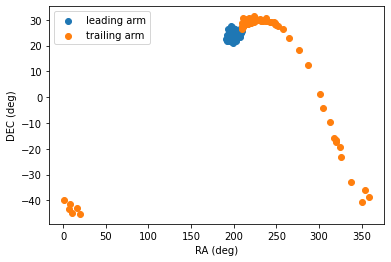

In [15]:
plt.scatter(oleading.ra(), oleading.dec(), label='leading arm')
plt.scatter(otrailing.ra(), otrailing.dec(), label='trailing arm')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

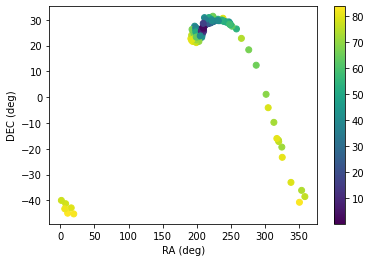

In [21]:
im = plt.scatter(oall.ra(), oall.dec(), c=dtall)
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.colorbar()

Text(0, 0.5, 'y (kpc)')

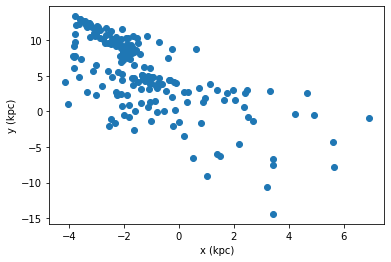

In [24]:
plt.scatter(oall.x(), oall.y())
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')

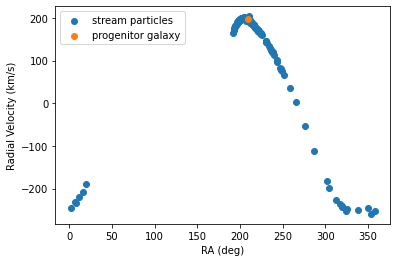

In [29]:
plt.scatter(oall.ra(), oall.vlos(), label='stream particles')
plt.scatter(o.ra(), o.vlos(), label='progenitor galaxy')
plt.xlabel('RA (deg)')
plt.ylabel('Radial Velocity (km/s)')
plt.legend();

<IPython.core.display.Javascript object>


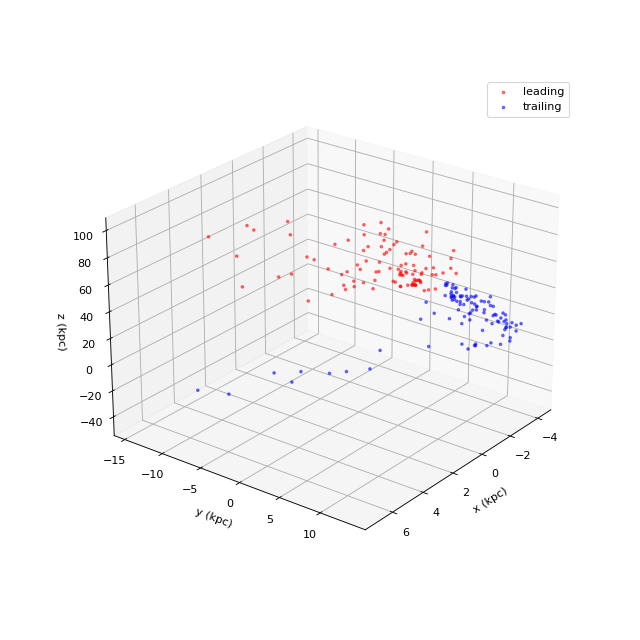

In [44]:
%matplotlib notebook

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
#oleading14.turn_physical_on()
ax.scatter(oleading.x(), oleading.y(), oleading.z(), marker='.', c='red', alpha=0.5, label='leading')
ax.scatter(otrailing.x(), otrailing.y(), otrailing.z(), marker='.', c='blue', alpha=0.5, label='trailing')
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')
ax.set_zlabel('z (kpc)')
ax.legend()

# Tips for plotting:
* Including more stars when sampling the stream will almost always produce better results
* If your stream is very spread out (and this is unexpected), check your work by *first* making sure that you aren't integrating the stream over too many orbital periods, and *second* rerunning the code with a reduced mass
* Generating contours around constrained regions of the stream may be very useful. This is one way to produce said contours that I found worked
```python
# index is the region over you want to produce the contour
x = np.array(oall.ra())[index]
y = np.array(oall.dec())[index]
stack = np.vstack((x, y))

 from scipy.stats import kde
k = kde.gaussian_kde(stack)
xi, yi = np.mgrid[x.min():x.max():20*1j, y.min():y.max():20*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

 # n is the number of contours
n = 3
plt.contour(xi, yi, zi.reshape(xi.shape), levels=n)
```